<a href="https://colab.research.google.com/github/markd87/googlecolab/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models

In [4]:
# Set device based on availability (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Load pretrained vgg19 model. strip away the classification head, keep only features
vgg = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [6]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
class StyleTransfer(nn.Module):
  def __init__(self):
    super(StyleTransfer, self).__init__()

    # Conv layers used for style (lower levels)
    self.style_layers = [0, 5, 10, 19, 28]

    # Conv layers used for context (deeper levels)
    self.content_layers = [21]

    self.model = models.vgg19(pretrained=True).features[:31]
    
    for i, layer in enumerate(self.model):
      if isinstance(layer, torch.nn.MaxPool2d):
        self.model[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

    for param in self.model.parameters():
      param.requires_grad = False


  def forward(self, image):
    style_features = []
    content_features = []
    for layer_index, layer in enumerate(self.model):
      image = layer(image)
      if layer_index in self.style_layers:
        style_features.append(image)
      elif layer_index in self.content_layers:
        content_features.append(image)
    return {'content': content_features, 'style':style_features}

In [8]:
def load_img(path_to_img):
  max_dim = 512
  image = Image.open(path_to_img)
  image.thumbnail((max_dim, max_dim))
  return image

def prepare_img(image):
  loader = transforms.Compose(
      [
       transforms.ToTensor(),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
      ]
  )

  # convert to tensor and add a batch axis
  image = loader(image).unsqueeze(0)

  return image.to(device)

In [9]:
def convert_img(image):
  """
  Convert a tensor of a batch of a single image 
  to a numpy arry
  """
  image = image.to('cpu').clone() # transfer to cpu
  image = image.squeeze(0).numpy() # remove batch axis, turn from tensor to numpy array
  image = image.transpose(1, 2, 0) # put channels at the last axis
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # reverse imagenet normalization
  image = np.clip(image, 0, 1)
  return image

In [10]:
def save_image(image, filename):
  """
  Save a numpy array with pixesl in range [0,1] as an image
  """
  rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
  im = Image.fromarray(rescaled, 'RGB')
  im.save(filename)

In [11]:
def gram_matrix(input):
  """ 
  Computes the gram matrix - the matrix of all inner products
  between all feature maps (channels) 
  """
  # result = torch.einsum('bcij,bdij -> bcd', input, input)
  b,c,h,w = input.shape
  input = input.view(c, h*w)
  result = torch.mm(input, input.t())
  return result

In [12]:
def style_loss(input, target):
  """
  mean square error of Gram matrices
  """
  b,c,h,w = target.shape
  gr_inp = gram_matrix(input)
  gr_tar = gram_matrix(target)
  return F.mse_loss(gr_inp, gr_tar)/ (c * h * w)

In [13]:
def variation_loss(input):
  """ smoothness loss, penalizes sharp edges on a one pixel scale """
  x_var = input[:,:,1:,:] - input[:,:,:-1,:]
  y_var = input[:,:,:,1:] - input[:,:,:,:-1]
  return torch.sum(torch.abs(x_var)) + torch.sum(torch.abs(y_var))

In [14]:
def content_loss(input, target):
  """ Mean square error loss between image pixels """
  return F.mse_loss(input, target)

In [39]:
def train(cont_img, 
          style_img, 
          epochs=500, 
          style_ratio=1e3, 
          variation_weight=1e-2, 
          save_intermediate=False, 
          save_name='gen_image'):
  """
  Generates an image by transferring style (style_image_path)
  to a content image (cont_image_path), with the style weight given
  by style_ratio and run epoch number of iterations. 
  Images are saved with the name prefix.
  """

  cont_img = prepare_img(cont_img)
  style_img = prepare_img(style_img)

  # the generated image is the input image which we clone
  # and set as requiring gradient i.e. trainable
  gen_img = cont_img.requires_grad_(True)
  # gen_img = torch.rand_like(cont_img).requires_grad_(True)

  # initialize model and move it to the device
  model = StyleTransfer().to(device).eval()

  # define optimizer, with the learning parameters being the input image
  optimizer = optim.Adam([gen_img], lr=0.03)

  # Training loop, updating the input image
  style_losses = []
  content_losses = []
  tot_losses = []
  
  orig_output = model(cont_img.detach())
  style_output = model(style_img.detach()) 
  content_target = orig_output['content']
  style_target = style_output['style']

  num_style_layers = len(style_target)
  num_content_layers = len(content_target)

  print(f"Training for {epochs} epochs, with style ratio: {style_ratio}")
  for i in notebook.tqdm(range(epochs)):
    
    # zero grad
    optimizer.zero_grad()

    gen_output = model(gen_img)
    gen_content = gen_output['content']
    gen_style = gen_output['style']


    style_loss_tot = 0
    cont_loss_tot = 0

    # compute style loss
    for j, stl in enumerate(gen_style):
      style_loss_tot += style_loss(stl, style_target[j])

    style_loss_tot /= num_style_layers

    # compute content loss
    cont_loss_tot = content_loss(gen_content[0], content_target[0])

    # weighted sum of style and content loss
    loss = style_ratio*style_loss_tot + cont_loss_tot
    loss += variation_weight*variation_loss(gen_img)

    # perform backpropogation
    loss.backward()
    # make gradient descent step
    optimizer.step()

    style_losses.append(style_ratio*style_loss_tot)
    content_losses.append(cont_loss_tot)
    tot_losses.append(loss)

    # save intermediate images
    if save_intermediate:
      if i%20 == 0 and i>0:
        print(f'saving image {i}')
        conv_img = convert_img(gen_img.detach())
        save_image(conv_img, save_name + '.jpg')

  plt.figure()
  plt.plot(np.log(style_losses), label='style loss', color='red')
  plt.plot(np.log(content_losses), label='content loss', color='blue')
  plt.plot(np.log(tot_losses), label='Total loss', color='black')
  plt.xlabel('epoch')
  plt.ylabel('log loss')
  plt.legend(frameon=False)

  plt.figure()
  conv_img = convert_img(gen_img.detach())
  plt.imshow(conv_img)
  print('saving final image')
  save_image(conv_img, save_name+'.jpg')

Training for 500 epochs, with style ratio: 1000.0



saving final image


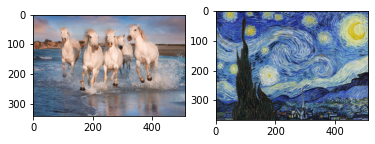

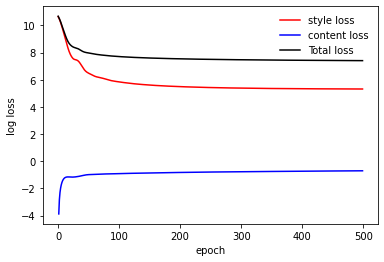

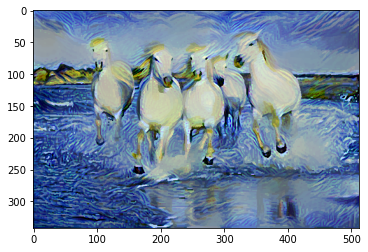

In [40]:
epochs = 500
style_ratio = 1e3
content_image = 'horses.jpg'
style_image = 'stary_night.jpg'
save_name = 'horses_stary'

cont_img = load_img(content_image)
style_img = load_img(style_image)

plt.subplot(1,2,1)
plt.imshow(cont_img)
plt.subplot(1,2,2)
plt.imshow(style_img)

train(cont_img, 
      style_img, 
      style_ratio=style_ratio, 
      epochs=epochs, 
      save_name=save_name)

Training for 1000 epochs, with style ratio: 100000.0



saving final image


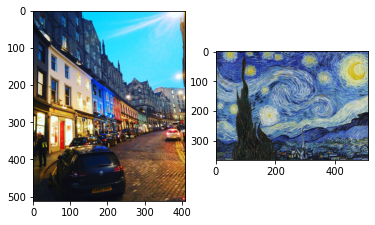

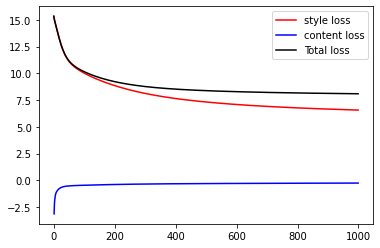

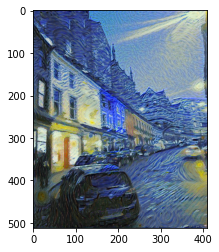

In [35]:
epochs = 1000
style_ratio = 1e5
content_image = 'edinb.jpg'
style_image = 'stary_night.jpg'
save_name = 'edinb_stary'

cont_img = load_img(content_image)
style_img = load_img(style_image)

plt.subplot(1,2,1)
plt.imshow(cont_img)
plt.subplot(1,2,2)
plt.imshow(style_img)

train(cont_img, 
      style_img, 
      style_ratio=style_ratio, 
      epochs=epochs, 
      save_name=save_name)

Training for 500 epochs, with style ratio: 1000.0



saving final image


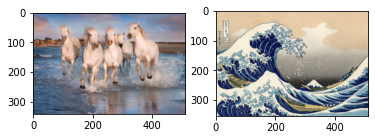

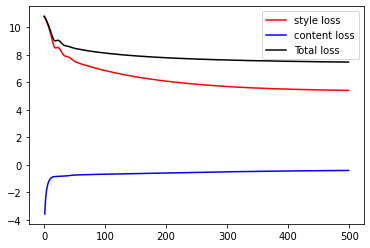

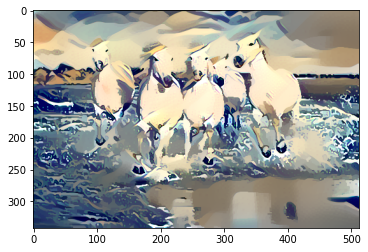

In [69]:
epochs = 500
style_ratio = 1e3
content_image = 'horses.jpg'
style_image = 'great_wave.jpg'
save_name = 'horses_wave'

cont_img = load_img(content_image)
style_img = load_img(style_image)

plt.subplot(1,2,1)
plt.imshow(cont_img)
plt.subplot(1,2,2)
plt.imshow(style_img)

train(cont_img, 
      style_img, 
      style_ratio=style_ratio, 
      epochs=epochs, 
      save_name=save_name)

Training for 500 epochs, with style ratio: 1000.0



saving final image


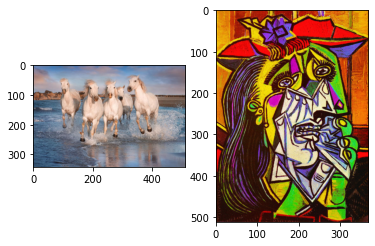

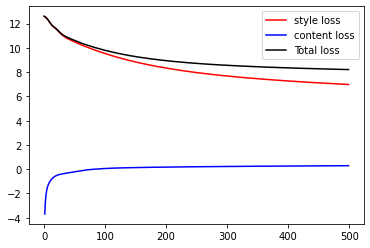

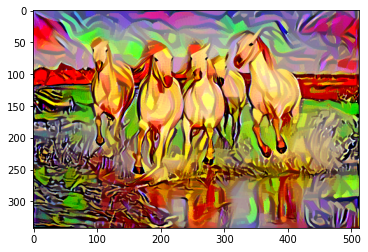

In [73]:
epochs = 500
style_ratio = 1e3
content_image = 'horses.jpg'
style_image = 'picaso.jpg'
save_name = 'horses_picaso'

cont_img = load_img(content_image)
style_img = load_img(style_image)

plt.subplot(1,2,1)
plt.imshow(cont_img)
plt.subplot(1,2,2)
plt.imshow(style_img)

train(cont_img, 
      style_img, 
      style_ratio=style_ratio, 
      epochs=epochs, 
      save_name=save_name)

Training for 200 epochs, with style ratio: 1000.0



saving final image


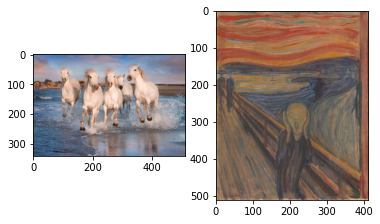

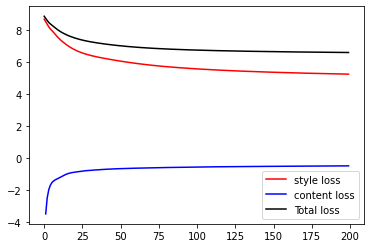

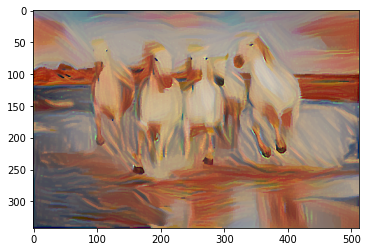

In [72]:
epochs = 200
style_ratio = 1e3
content_image = 'horses.jpg'
style_image = 'munch.jpg'
save_name = 'horses_munch'

cont_img = load_img(content_image)
style_img = load_img(style_image)

plt.subplot(1,2,1)
plt.imshow(cont_img)
plt.subplot(1,2,2)
plt.imshow(style_img)

train(cont_img, 
      style_img, 
      style_ratio=style_ratio, 
      epochs=epochs, 
      save_name=save_name)